# Online Shoppers Intentions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt
%matplotlib inline

#Modelling
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold, RepeatedKFold, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression,  Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.svm import NuSVC, SVC
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, plot_confusion_matrix, f1_score
from scipy.signal import hilbert, hann, convolve
from scipy import stats
import xgboost as xgb

pd.options.display.precision = 15

import time
from datetime import datetime, date
import json
import ast

import gc
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML

### Load data

In [330]:
df = pd.read_csv('online_shoppers_intention.csv')
print('Rows and Columns of data')
print(df.shape)
df.head()

Rows and Columns of data
(12330, 18)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


### Missing Values

Check on whether any missing values are present in the data

In [331]:
pd.DataFrame(df.isnull().sum(), columns=['Missing Values'])

,Missing Values
Administrative,14
Administrative_Duration,14
Informational,14
Informational_Duration,14
ProductRelated,14
ProductRelated_Duration,14
BounceRates,14
ExitRates,14
PageValues,0
SpecialDay,0


As can be seen from the table above there are 14 missing values for 8 of the variables. Due to the small number a decision is made to remove these from the data.

## Description of Data

Using the describe function will generate a summary of each variable in the dataset.

In [332]:
df.dropna(inplace=True)
round(df.describe(include='all'),1).transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Administrative,12316,NaN,NaN,NaN,2.3,3.3,0,0,1,4,27
Administrative_Duration,12316,NaN,NaN,NaN,80.9,176.9,-1,0,8,93.5,3398.8
Informational,12316,NaN,NaN,NaN,0.5,1.3,0,0,0,0,24
Informational_Duration,12316,NaN,NaN,NaN,34.5,140.8,-1,0,0,0,2549.4
ProductRelated,12316,NaN,NaN,NaN,31.8,44.5,0,7,18,38,705
ProductRelated_Duration,12316,NaN,NaN,NaN,1196,1914.4,-1,185,599.8,1466.5,63973.5
BounceRates,12316,NaN,NaN,NaN,0,0,0,0,0,0,0.2
ExitRates,12316,NaN,NaN,NaN,0,0,0,0,0,0,0.2
PageValues,12316,NaN,NaN,NaN,5.9,18.6,0,0,0,0,361.8
SpecialDay,12316,NaN,NaN,NaN,0.1,0.2,0,0,0,0,1


The data appears to be a mix of continuous (variables 1 - 9) and categorical (variables 10-17) data and the 2 types will be separated for data analysis. The revenue variable will be used as the target.

### Continuous Variables

By plotting the continuous variables for those visitors who have /haven't purcahsed anything can highlight any obvious differences in behaviour

In [10]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(3,3,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(3,3,i)
        df1[feature].plot.kde(label=label1)
        df2[feature].plot.kde(label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.legend()
        plt.tick_params(axis='x', which='major', labelsize=10, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=10)
    plt.show()

<Figure size 432x288 with 0 Axes>

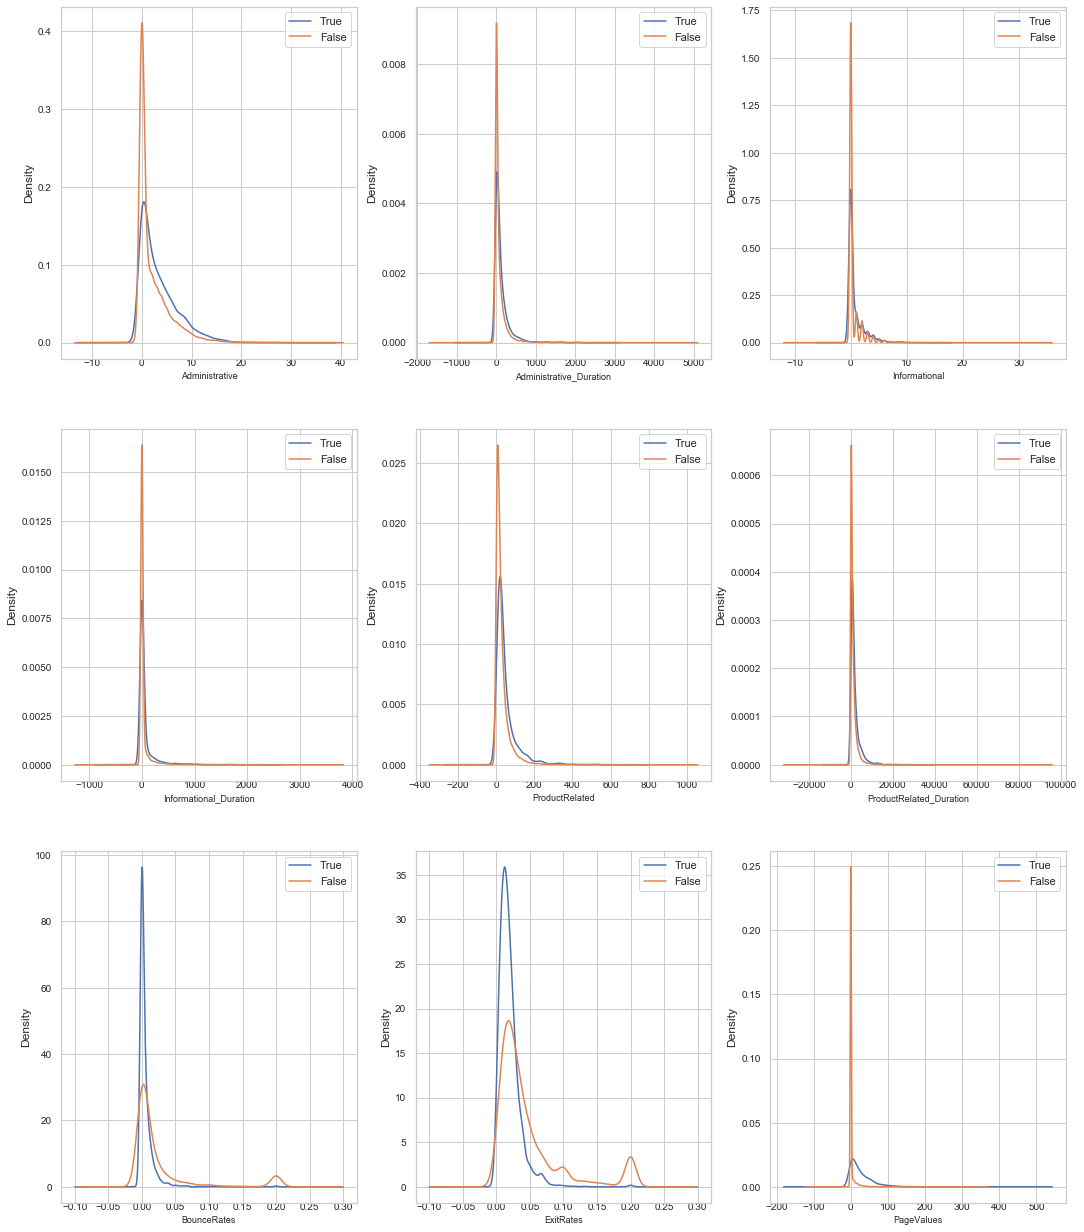

In [191]:
col_list = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated',
       'ProductRelated_Duration', 'BounceRates', 'ExitRates',
       'PageValues']

t0 = df.loc[df['Revenue'] == True]
t1 = df.loc[df['Revenue'] == False]
plot_feature_distribution(t0, t1, 'True', 'False', features=col_list)

For some of these variables there appears to be obvious differences, Bounce rates, exit rates and Page Values the most obvious ones. 

By plotting the correlation of these variables it can be noted whether there are any variables with high correlation to one another and if any action in treating the data should be taken based on these correlations.

### Correlation Matrix

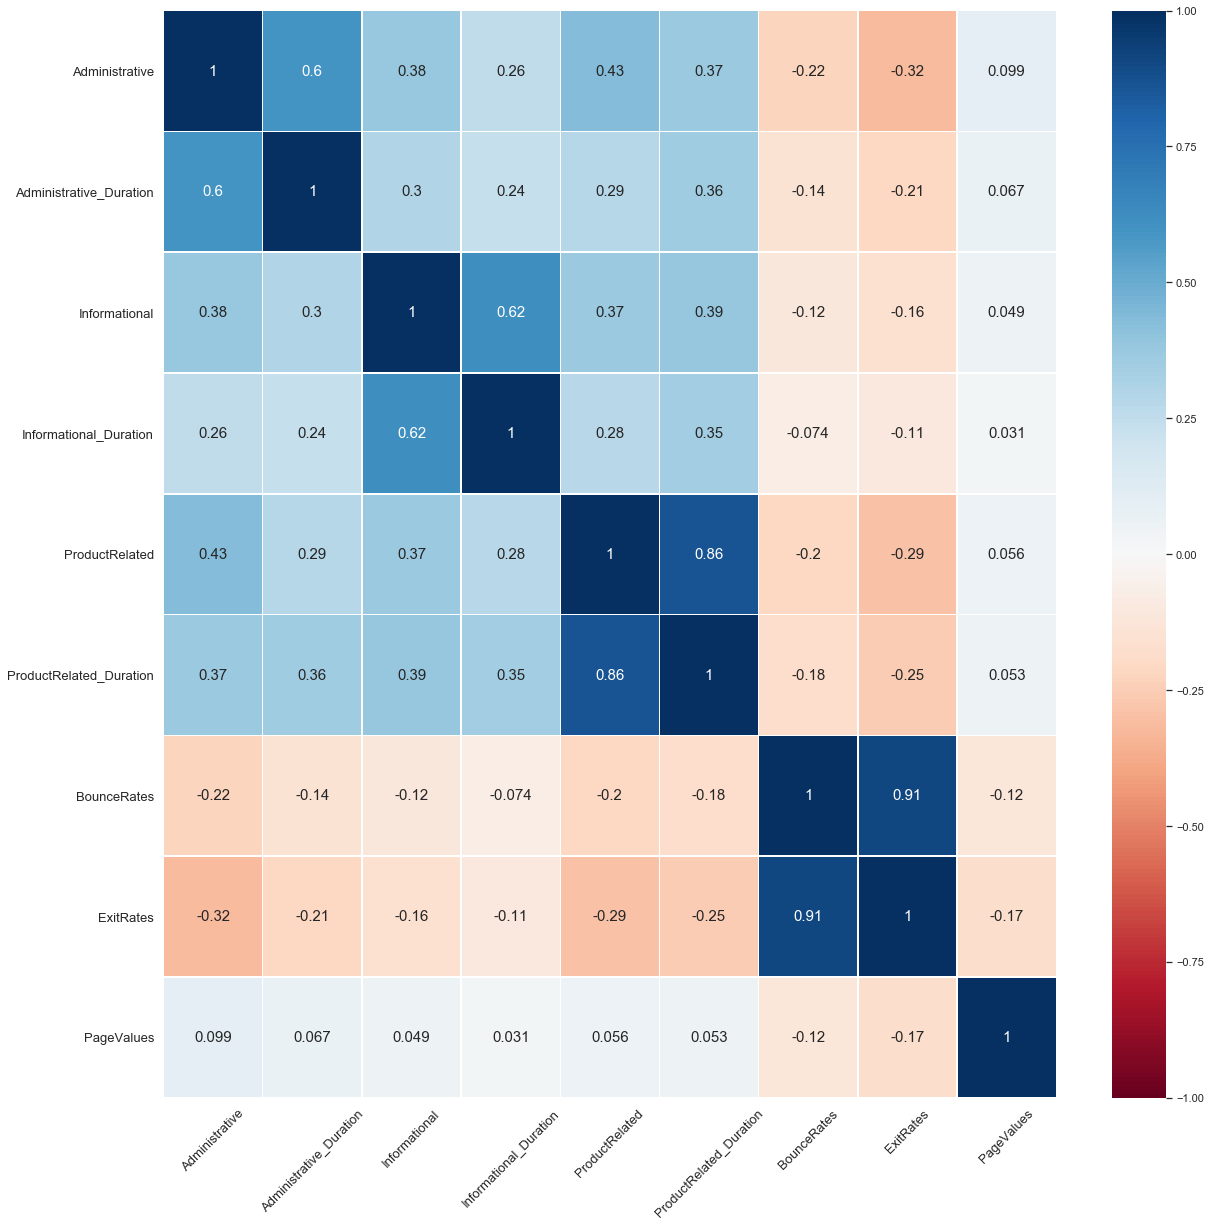

In [195]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale=1) 
ax = sns.heatmap(df[col_list].corr(), center=0, linewidths=0.5, 
                 cmap="RdBu", vmin=-1, vmax=1, annot=True, ax=ax, annot_kws={"size": 15})

ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45, fontsize=13)
ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0, fontsize=13);

It can be seen that ProductRelated & ProductRelated_Duration are highly correlated and BounceRates & ExitRates are heavily correlated. However if a high threshold for removal was introduced (say 0.95) then these 2 sets of variables would not  be removed and at this stage none of them will be removed.

## Categorical Variables 

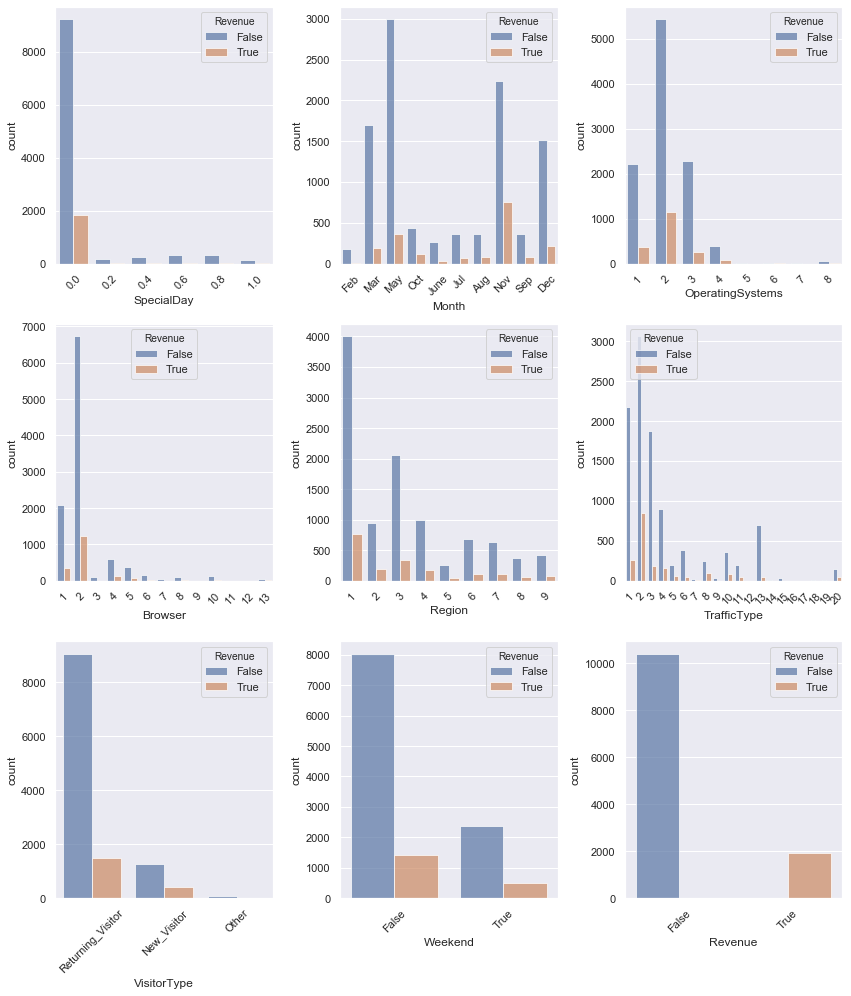

In [204]:
dat_cat = df[df.columns[~df.columns.isin(col_list)]]
    
fig, axes = plt.subplots(round(len(dat_cat.columns) / 3), 3, figsize=(12, 14))

for i, ax in enumerate(fig.axes):
    if i < len(dat_cat.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=dat_cat.columns[i], alpha=0.7, data=dat_cat, hue='Revenue',  ax=ax)
fig.tight_layout()

An obvious observation from this set of variables is that those who visit in November have a relatively high likelihood of purcahsing where as those who visit in May are more likely to view more than purchase.

## Modelling

With the data structured into the correct format, the exciting part can be conducted and a series of model built to understand their ability to predict whether a customer makes a purchase or not.

In [333]:
#Convert categorical variables to dummy variables

df = pd.get_dummies(df, columns=['SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 
                                'VisitorType', 'Weekend'])

X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=123)

#Some of the classification models are 
scaling = MinMaxScaler(feature_range=(0,1)).fit(X_train)
X_train_sc = scaling.transform(X_train)
X_test_sc = scaling.transform(X_test)

### Set a function to feed each different model and parameters into

In [218]:
def model_eval(model, grid, X_train, y_train):

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state = 123)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0,verbose=1)
    grid_result = grid_search.fit(X_train, y_train)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    return (grid_result, means, stds, params)

### 1. Logistic Regression

In [211]:
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1', 'l2']
c_values = [50, 20, 10, 1.0, 0.1, 0.01]
# define grid search

grid = dict(solver=solvers,penalty=penalty,C=c_values)

log_cv = model_eval(model, grid, X_train, y_train);

#Full results can be displayed with the following code
#for mean, stdev, param in zip(knn_cv[0], knn_cv[1], knn_cv[2]):
#    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 30 folds for each of 36 candidates, totalling 1080 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 522 tasks      | elapsed:  4.4min
[Parallel(n_jobs=8)]: Done 904 tasks      | elapsed:  5.8min
[Parallel(n_jobs=8)]: Done 1080 out of 1080 | elapsed:  6.3min finished


Best: 0.495556 using {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}


### 2. K Nearest Neighbours

In [214]:
# define models and parameters
model = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)

knn_cv = model_eval(model, grid, X_train_sc, y_train)

#Full results can be displayed with the following code
#for mean, stdev, param in zip(knn_cv[0], knn_cv[1], knn_cv[2]):
#    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 30 folds for each of 60 candidates, totalling 1800 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  7.2min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed: 11.4min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed: 16.6min
[Parallel(n_jobs=8)]: Done 1800 out of 1800 | elapsed: 16.7min finished


Best: 0.321320 using {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}


### 3. Support Vector Machines

In [216]:
model = SVC()
kernel = ['poly', 'rbf', 'linear']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C, gamma=gamma)

svm_cv = model_eval(model, grid, X_train_sc, y_train);

#Full results can be displayed with the following code
#for mean, stdev, param in zip(svm_cv[0], svm_cv[1], svm_cv[2]):
#    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 30 folds for each of 15 candidates, totalling 450 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  8.8min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 16.1min
[Parallel(n_jobs=8)]: Done 450 out of 450 | elapsed: 16.4min finished


Best: 0.504423 using {'C': 50, 'gamma': 'scale', 'kernel': 'linear'}


### 4. Guassian Naive Bayes

In [240]:
# define models and parameters
model = GaussianNB()
# define grid search

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state = 123)
params = {}
grid_search = GridSearchCV(nb, cv=cv, param_grid=params, n_jobs=-1, scoring='f1',error_score=0,verbose=1)
grid_result = grid_search.fit(X_train, y_train)

print("Cross Val Score: %f" % (grid_result.best_score_))


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Cross Val Score: 0.412440


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished


### 5. Random Forest

#### a. Randomised Search

In [247]:
# define models and parameters
model = RandomForestClassifier()
n_estimators = [100, 250, 500, 1000]
bootstrap = [True, False],
max_depth = [10, 25, 50, 75, 100, 200, None]
max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 5, 10]
# define grid search
grid = dict(n_estimators=n_estimators, bootstrap=bootstrap, max_depth=max_depth, max_features=max_features, 
            min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)

rf_random = RandomizedSearchCV(estimator = model, param_distributions = grid, n_iter = 100, 
                               cv = 3, verbose=1, scoring='f1', error_score=0, random_state=123, n_jobs = -1)

grid_result = rf_random.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.2min finished


Best: 0.611959 using {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': [True, False]}


#### b. Further tuning based on best randomised search results

In [248]:
# define models and parameters
model = RandomForestClassifier()

# Create the parameter grid based on the results of random search 
grid = {
    'bootstrap': [True],
    'max_depth': [75, 100, None],
    'max_features': ['sqrt'],
    'min_samples_leaf': [0.75, 1, 1.5, 2],
    'min_samples_split': [4,5,6],
    'n_estimators': [400,500,600]
}

rf_cv = model_eval(model, grid, X_train, y_train)

Fitting 30 folds for each of 108 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 36.7min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 38.1min finished


Best: 0.615851 using {'bootstrap': True, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 400}


With further tuning of the best randomised parameters achieved a slightly better F1 cross validation score was achieved. A larger set of values within each parameter could be used if processing time was not a problem, but in this case the CV sore is a big improvement on some of the other models already tested. 

### 6. Gradient Boosting

In [124]:
# define models and parameters
model = GradientBoostingClassifier()
n_estimators = [10, 100, 1000]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]
# define grid search
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)

gbm_cv = model_eval(model, grid, X_train, y_train)

#Full results can be displayed with the following code
#for mean, stdev, param in zip(svm_cv[0], svm_cv[1], svm_cv[2]):
#    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 30 folds for each of 81 candidates, totalling 2430 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   58.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  7.6min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed: 36.6min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed: 50.3min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed: 85.5min
[Parallel(n_jobs=8)]: Done 2430 out of 2430 | elapsed: 118.6min finished


Best: 0.650935 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}


Gradient Boosting has achieved a better cross validation score than the random forest model.

### 7. Xgboost

In addition to gradient boosting, the Xgboost model will also be trained and validated.

In [46]:
model = xgb.XGBClassifier()

start = time.time()
grid = dict({  'learning_rate': [0.1,0.3,0.5],
               'n_estimators': [50, 100, 200],
               'max_depth': [2, 4, 6],
               'min_child_weight': [2, 4, 6],
               'gamma': [0],
               'subsample': [0.2,0.5,1],
               'colsample_by_tree': [0.2,0.5,1]})

xg_cv = model_eval(model, grid, X_train, y_train)

elapsed = time.time() - start
print(elapsed);

Fitting 30 folds for each of 729 candidates, totalling 21870 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   32.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  6.5min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed: 11.4min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed: 19.2min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed: 22.4min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed: 28.9min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed: 38.2min
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed: 43.9min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed: 54.8min
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed: 62.5min
[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed: 75.4min
[Parallel(n_jobs=8)]: Done 11234 tasks      | elapsed: 83.9mi

Best: 0.656969 using {'colsample_by_tree': 0.2, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 50, 'subsample': 1}
10424.653497457504


## Summary

In [302]:
data = {'Logistic Regression': [round(log_cv[0].best_score_,2), round(f1_score(y_test, log_cv[0].predict(X_test)),2)],
        'KNN':[round(knn_cv[0].best_score_,2), round(f1_score(y_test, knn_cv[0].predict(X_test_sc)),2)],
       'SVM': [round(svm_cv[0].best_score_,2), round(f1_score(y_test, svm_cv[0].predict(X_test_sc)),2)],
       'Naive Bayes': [round(nb_cv[0].best_score_,2), round(f1_score(y_test, nb_cv[0].predict(X_test_sc)),2)],
       'Random Forest': [round(rf_cv[0].best_score_,2), round(f1_score(y_test, rf_cv[0].predict(X_test)),2)],
       'Gradient Boosting': [round(gbm_cv[0].best_score_,2), round(f1_score(y_test, gbm_cv[0].predict(X_test)),2)],
       'Xgboost': [round(xg_cv[0].best_score_,2), round(f1_score(y_test, xg_cv[0].predict(X_test)),2)]}
pd.DataFrame(data, index=['CV', 'Validation'])

,Logistic Regression,KNN,SVM,Naive Bayes,Random Forest,Gradient Boosting,Xgboost
CV,0.5,0.32,0.50,0.30,0.62,0.65,0.66
Validation,0.5,0.34,0.51,0.31,0.64,0.67,0.68


Results show that the Xgboost model has the highest CV and validation F1 scores. With cross validation and validation accuracy having similar scores, there is a confidence that the better performing models are not overfitted on the training data and will generalise well.
Using the Xgboost model, the importance features can be highlighted as well as displaying the results in a confusion matrix to understand it's precision and recall.

In [320]:
params = xg_cv[0].best_params_
xg = xgb.XGBClassifier(**params)
classifier = xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)

### Accuracy of Xgboost

In addition to the F1 score, the accuracy of the model is

In [322]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.87%


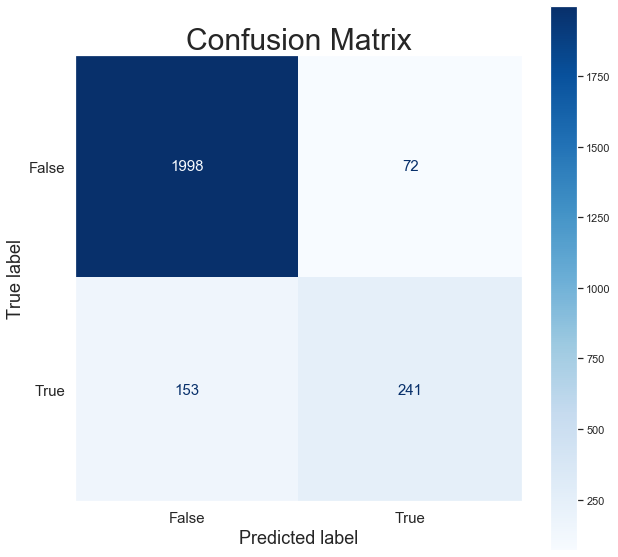

In [324]:
class_names = ['False', 'True']

fig, ax = plt.subplots(figsize=(10,10))
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'30'}  # Adjust to fit
ax.set_title('Confusion Matrix', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit

plt.rc('font', size=15)

disp = plot_confusion_matrix(classifier, X_test, y_test, display_labels = class_names, cmap=plt.cm.Blues,
                            values_format = 'g', ax=ax)

plt.grid(False)
  
plt.show()
#, ['False','True'])

As can be seen from the matrix, the Type II errors (72 False predictions that actually purchased) is much lower than the Type I errors (153) which is good in the sense that the model is not missing many customers that actually purcahse. The type I errors may be displaying behaviours of those who do purcahse of which more analysis could be produced. An output of this model could be to retarget users online who are believed to be likely to purcahse based upon the model prediction.

### XGboost Feature Importance

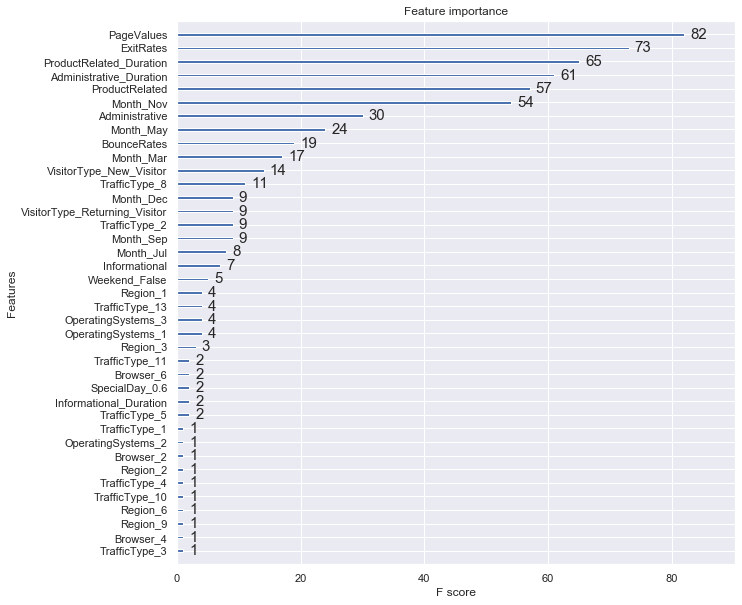

In [327]:
from xgboost import plot_importance
from matplotlib import pyplot
fig, ax = plt.subplots(figsize=(10,10))

plot_importance(xg, ax=ax)
pyplot.show()

From the feature importance output there are 5 variables that appear to be the strongest predictors. Based on some of the earlier analysis into distributions for those that do purchase this makes sense. A higher page value is most likely a product page (which can lead to a transaction), lower exit rates mean the customer is engaged and not leaving the site. 